# Black Box Variational Inference on Diagnostic Classification Models

$\textbf{Motivation behind ELBO cost function}$

The evidence lower bound is a lower bound of the log marginalized joint distribution $p(x, z)$. The value $\log p(x)$ is called the evidence.
$$\log p(x) = \log\left( \int p(x, z) dz\right)$$
$$ = \log \left(\int p(x, z)\frac{q(z)}{q(z)} dz\right)$$
$$ = \log \left(E_q\left[\frac{p(x, z)}{q(z)}\right]\right)$$
$$ \geq E_q[\log p(x, z)] - E_q[\log q(z)] \quad \text{(ELBO)}$$
The last term obtained via Jensen's inequality and linearity of expectation. It is referred to as the evidence lower bound. The ELBO shows up in variational inference as an alternative cost function to the KL divergence.
$$KL(q||p) = E_q\left[\log\left(\frac{q(z)}{p(z|x)}\right)\right]$$
$$ = E_q[\log q(z)] - E_q[\log p(z|x)]$$
$$ = E_q[\log q(z)] - E_q[\log p(x, z)] + E_q[\log p(x)]$$
$$ = -\text{ELBO} + \log p(x)$$
Since the goal of variational inference is to optimize the parameters of $q$, maximizing the ELBO with respect to $q$ is equivalent to minimizing the KL divergence with respect to $q$.

$\textbf{Noisy Gradient of the ELBO}$

The minimizer of the ELBO does not always have an analytical form. Instead, gradient ascent is used to find the maximizer. An unbiased estimator of the gradient is obtained by sampling from variational distirbution $q$.
The gradient of the ELBO is 
$$\nabla_{\lambda}L = E_q[\nabla_{\lambda}\log q(z|\lambda) (\log p(x, z) - \log q(z|\lambda))]$$
Assume each latent variable $z$ is governed by independent variational distributions such that $q(z|\lambda) = \prod_{i = 1}^n q(z_i|\lambda_i)$. Equation 5 from (Ranganath et. al., 2013) gives the Rao-Blackwellized estimator of the gradient for individual $\lambda_i$.
$$\nabla_{\lambda_i}L = E_{q_{(i)}}[\nabla_{\lambda_i}\log q(z_i|\lambda_i)(\log p_i(x, z_{(i)}) - \log q(z_i|\lambda_i))]$$
$E_{q_{(i)}}$ is the expectation with respect to the markov blanket of $z_i$, or the variables that depend on $z_i$, and $p_i(x, z_{(i)})$ is the terms of the join distribution that depend on $x$ and $z_i$.

$\textbf{Diagnostic Classification Model (DCM)}$

In this problem setting, there are $I$ items on an assesment, and each item measures up to $A$ attributes. Each latent class $c$ has an attribute profile $Z_c = [z_{c1}, ..., z_{cA}] \in \{0, 1\}^A$ where $z_{ca} = 0$ indicates that the $a$-th attribute is not mastered and $z_{ca} = 1$ indicates that the $a$-th attribute is mastered in latent class $c$. 

$Q \in \{0, 1\}^{I \times A}$ is called the Q matrix and $q_{ia}$ indicates whether question $i$ measures mastery of attribute $a$. 0 indicates that the attribute is not measured and 1 indicates that it is measured.

$\Delta_i = (\delta_{i1}, ..., \delta_{iL})^T$ is the feature matrix for item $i$, where each row is indexed by an attribute profile and the columns are the attributes and all the interactions of attributes measured by an item on the assesment. 1 indicates that the attributes in the interaction term are all mastered in the attributes profile. 0 indicates that at least 1 attribute in the interaction is not mastered in the attribute profile.

For example, consider that item $i$ measures mastery of 2 attributes. There are $L = 4$ possible attribute profiles (00, 01, 10, 11) corresponding to no masteries, mastering attribute 1, mastering attribute 2, and mastering both attributes. There are 4 features in $\Delta_i$ (00, 01, 10, 11) corresponding to intercept, main effect of attribute 1 mastery, main effect of attribute 2 mastery, and interaction effect.

$$
\begin{array}{ccccc} 
   & \textbf{00} & \textbf{01} & \textbf{10} & \textbf{11}\\
\textbf{00} & 1 & 0 & 0 & 0\\
\textbf{01} & 1 & 1 & 0 & 0\\
\textbf{10} & 1 & 0 & 1 & 0\\
\textbf{11} & 1 & 1 & 1 & 1
\end{array}
$$

The DCM models $\pi_{ic} = P(Y_{ic} = 1 | Z_c)$, the probability of a respondent with attribute profile $Z_c$ answering the $i$-th item correctly.

Let $\sigma$ be the sigmoid function, $\sigma(x) = \frac{1}{1 + e^{-x}}$
$$\pi_{ic} = \sigma(\beta_i^T\delta_{ic})$$
$$P(Y_{ic} = y_{ic} | Z_c) = (\pi_{ic})^{y_{ic}} \cdot (1 - \pi_{ic})^{1 - y_{ic}}$$
$$ = \sigma((2y_{ic} - 1)\beta_i^T\delta_{ic}) \quad \text{(Only true when $y_{ic} \in \{0, 1\}$)}$$

## Naive Black Box 

In this section black box variational inference will be used to estimate the parameters of a DCM model. Data is generated according to the probability model shown below. 

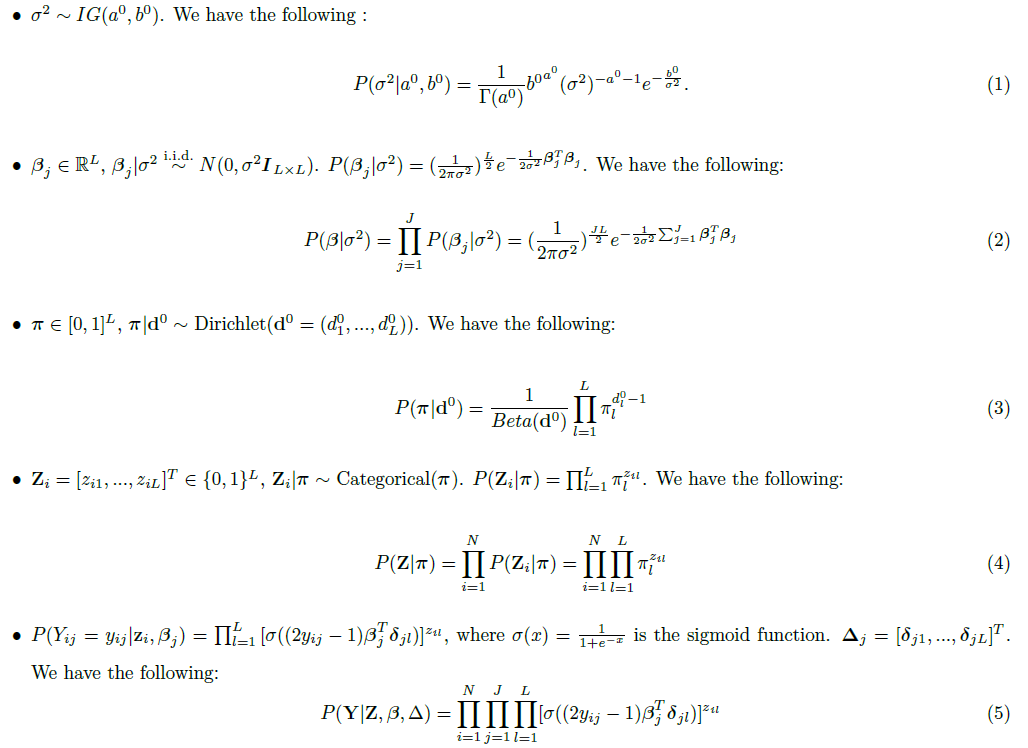

In [1]:
display("image/png", read("DCM probability model.png"))

The joint distribution is 
$$P(Y, Z, \beta, \pi, \sigma^2 | \Delta, d^0, a^0, b^0) = P(Y|Z,\beta,\Delta)P(Z|\pi)P(\pi|d^0)P(\beta|\sigma^2)P(\sigma^2|a^0,b^0)$$
$$ = \prod_{i = 1}^N\prod_{j = 1}^J\prod_{l = 1}^L [\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})]^{z_{il}} \cdot \prod_{i = 1}^N\prod_{l = 1}^L \pi_l^{z_{il}} \cdot \frac{1}{\text{Beta}(d^0)}\prod_{l = 1}^L \pi_l^{d^0_l - 1} \cdot \left(\frac{1}{2\pi\sigma^2}\right)^{\frac{JL}{2}}e^{-\frac{1}{2\sigma^2}\sum_{j = 1}^J\beta_j^T\beta_j} \cdot \frac{1}{\Gamma(a^0)}(b^0)^{a^0}(\sigma^2)^{-a^0 - 1}e^{-\frac{b^0}{\sigma^2}}$$

The variational distribution follows the mean field family
$$Q(Z, \beta, \pi, \sigma^2) = q_1(Z)q_2(\beta)q_3(\pi)q_4(\sigma^2)$$
$$ = \left(\prod_{i = 1}^Nq_{1i}(Z_i)\right)\left(\prod_{j = 1}^Jq_{2j}(\beta_j)\right)q_3(\pi)q_4(\sigma^2)$$
$$Z_i \sim \text{Categorical}(\pi_i^*) \quad \beta_j \sim N(\mu_j^*, V_j^*) \quad \pi \sim \text{Dirichlet}(d^*) \quad \sigma^2 \sim IG(a^*, b^*)$$

$\textbf{Noisy Gradient of }q_{1i}(Z_i)$

Since $q_{1i}$ is a categorical distribution, it can be parameterized by logits $\rho^*_{i} = \{\rho^*_{i1}, ..., \rho^*_{iL}\}$ such that $\pi^*_{il} = \frac{e^{\rho^*_{il}}}{\sum_{k = 1}^L e^{\rho^*_{ik}}}$ are obtained by the softmax transformation.

$$
\begin{aligned}
\log(q_{1i}(Z_i)) & = \sum_{l = 1}^{L}z_{il}\log(\pi_{il}^*)\\
\nabla_{\rho_{i}^*}\log(q_{1i}(Z_i)) & = Z_{i} - \pi_{i}^* \quad \text{(Equivalent to gradient of logit w.r.t cross entropy loss)}\\
\log(p(Y, Z_{(i)})) & = \sum_{j = 1}^J\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) + \sum_{l = 1}^Lz_{il}\log(\pi_l)
\end{aligned}
$$
Note that $\pi_l$ are latent variables in the probability model different from $\pi_{il}^*$ which are the parameters of the variational distribution. 

The gradient is approximated by sampling 

$$Z_{im} \sim q_{1i}(Z_i|\pi_i^*), \quad \beta_{jm} \sim q_{2j}(\beta_j|\mu_j^*, V_j^*), \quad \pi_m \sim q_4(\pi|d^*), \quad \text{for } m = 1, 2, ..., M$$

and taking the following average

$$
\begin{aligned}
\nabla_{\rho_{i}^*}L & = E_{q_{1i}(Z_i)}[\nabla_{\rho_{il}^*}\log(q_{1i}(Z_i))\cdot(\log(p(Y,Z_{(i)})) - \log(q_{1i}(Z_i)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\left(Z_{im} - \pi_{il}^*\right)\cdot\left(\sum_{j = 1}^J\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl}))\right.\right.\\
 & \left.\left.+ \sum_{l = 1}^Lz_{iml}\log(\pi_{ml}) - \sum_{l = 1}^{L}z_{iml}\log(\pi_{il}^*)\right)\right]
\end{aligned}
$$

$\textbf{Noisy Gradient of }q_{2j}(\beta_j)$

To ensure that all gradient updates remain within the positive semi definite cone, let $V_j^* = C^*_jC^{*T}_j$ where $C^*_j$ is the lower triangular Cholesky factor of the Cholesky decomposition of $V_j^*$. We will update $C^*_j$ via noisy gradient descent. 

Let $k_j$ be the length of $\beta_j$ or the number of features.

$$
\begin{aligned}
\log(q_{2j}(\beta_j)) & = -\frac{k_j}{2}\log(2\pi) - \frac{1}{2}\log(|V_j^*|) - \frac{1}{2}(\beta_j - \mu_j^*)^T(V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{\mu_j^*}\log(q_{2j}(\beta_j)) & = (V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{V_j^*}\log(q_{2j}(\beta_j)) & = \frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\\
\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C^*_j)} & = \frac{d\log(q_{2j}(\beta_j))}{d\text{ vec}(V_j^*)} \cdot \frac{d\text{ vec}(V_j^*)}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{V_j^*}\log(q_{2j}(\beta_j))\right) \cdot \frac{d\text{ vec}(V_j^*)}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{V_j^*}\log(q_{2j}(\beta_j))\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
 & = \text{vec}\left(\frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
\log(p(Y, \beta_{(j)})) & = \sum_{i = 1}^N\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) - \frac{1}{2\sigma^2}\beta_j^T\beta_j
\end{aligned}
$$
**vec** and **vech** are the [vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) and [half vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Half-vectorization) operations for matricies. $\otimes$ is the kronecker product. $K_{k_j}$ is the [commutation matrix](https://en.wikipedia.org/wiki/Commutation_matrix) for the vectorization of a $k_j$ by $k_j$ matrix. 

i.e. If $A \in R^{k_j \times k_j}$ then $K_{k_j}\text{vec}(A) = \text{vec}(A^T)$

$D_{k_j}$ is the duplication matrix for a lower triangular $k_j$ by $k_j$ matrix.

i.e. If $A$ is a lower triangular $k_j$ by $k_j$ matrix then $D_{k_j}\text{vech}(A) = \text{vec}(A)$ (Note: This is not the same as the duplication matrix for symmetric A)

The gradient is approximated by sampling
$$Z_{im} \sim q_{1i}(Z_i|\pi_i^*), \quad \beta_{jm} \sim q_{2j}(\beta_j|\mu_j^*, V_j^*), \quad \sigma_m \sim q_3(\sigma|a^*, b^*), \quad \text{for } m = 1, 2, ..., M$$

and taking the following averages

$$
\begin{aligned}
\nabla_{\mu_{j}^*}L & = E_{q_{2j}(\beta_j)}[\nabla_{\mu_{j}^*}\log(q_{2j}(\beta_j))\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[(V_j^*)^{-1}(\beta_{jm} - \mu_j^*) \cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm}\right.\right.\\
 & \left.\left.+ \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]\\
\frac{dL}{d\text{ vech}(C_j)} & = E_{q_{2j}(\beta_j)}\left[\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C_j)}\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))\right]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\text{vec}\left(\frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\right) \cdot \left[C_j\otimes I + I\otimes C_j K_{k_j}\right]D_{k_j}\right.\\ 
 & \left.\cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm} + \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]
\end{aligned}
$$

$\textbf{Noisy Gradient of }q_{3}(\pi)$


In [1]:
using LinearAlgebra
include("BBVI_modeling.jl")

In [2]:
using RCall

R"""
load("data.RData")
"""
data = @rget data
Y = data[:Y]
Q = convert(Matrix{Int64}, data[:Q])
obs = DCMObs(Y, Q);

In [3]:
a0 = 1e-2
b0 = 1e-4
d0 = ones(size(obs.D[1], 1))
M = 1000
model = DCModel(obs, d0, a0, b0, M);

In [19]:
# Large step size for moving in logit space
update_pi_star(model, step = 2.0, maxiter = 20)

In [5]:
update_mu_star_V_star(model, step = 1e-3, maxiter = 15, verbose = true)

ELBO: -915.7456081402009
mu*_1: [0.0, 0.0, 0.0, 0.0]
gradient mu: [81.41594668456146, 30.592582200309486, 40.83546524071811, 12.5945228745197]
C*_1: [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
gradient C: [-180.27752634691817 0.0 0.0 0.0; -68.5832140875442 -92.31597952971617 0.0 0.0; -91.86171643751165 -33.785249897068894 -78.61765077131494 0.0; -33.92566531156503 -50.96347624396264 -26.624978062554952 -21.103134934524256]
ELBO: -844.4343867815596
mu*_1: [0.08141594668456147, 0.030592582200309488, 0.040835465240718107, 0.0125945228745197]
gradient mu: [79.16123191903247, 19.680384655100266, 21.245413499628444, 22.968695182768805]
C*_1: [0.8197224736530818 0.0 0.0 0.0; -0.06858321408754421 0.9076840204702838 0.0 0.0; -0.09186171643751165 -0.033785249897068895 0.921382349228685 0.0; -0.033925665311565024 -0.05096347624396264 -0.026624978062554955 0.9788968650654758]
gradient C: [-162.19624116021137 0.0 0.0 0.0; -45.43261828389645 -86.0537090340923 0.0 0.0; -65.97

In [ ]:
update_d_star(model, step = 1e-3, maxiter = 50)

In [ ]:
update_a_star_b_star(model, step = 1e-3, maxiter = 20)

In [4]:
K = 1
for k in 1:K
    println("iter: $k")
    update_pi_star(model, step = 1e-2, maxiter = 20, verbose = false)
    update_mu_star_V_star(model, step = 1e-3, maxiter = 30, verbose = false)
    update_d_star(model, step = 1e-3, maxiter = 20, verbose = false)
    update_a_star_b_star(model, step = 1e-3, maxiter = 20, verbose = false)
end

iter: 1


DomainError: DomainError with NaN:
InverseGamma: the condition α > zero(α) is not satisfied.

In [15]:
model.a_star

1-element Vector{Float64}:
 NaN

In [12]:
model.pi_star

1000-element Vector{Vector{Float64}}:
 [0.298026739823276, 0.22414961567430614, 0.2852885592324136, 0.19253508527000424]
 [0.2974675817790022, 0.23387846104661894, 0.27996790306360037, 0.1886860541107785]
 [0.2814566902966464, 0.23930163752824615, 0.27609516062575323, 0.20314651154935426]
 [0.291438377080994, 0.2451796241836177, 0.2574082082801, 0.2059737904552884]
 [0.27995940396407304, 0.24119666568730488, 0.27803994646989544, 0.20080398387872656]
 [0.27345402459603346, 0.2310367354397417, 0.2780302415347717, 0.21747899842945337]
 [0.3046631209261287, 0.2211995779474567, 0.28171609271415776, 0.19242120841225688]
 [0.3009789751752755, 0.24476976241656778, 0.26356263716486705, 0.19068862524328975]
 [0.2909218682972183, 0.23113945342864975, 0.28170906334935975, 0.1962296149247721]
 [0.31286097218755543, 0.2230886355616877, 0.2744628453429963, 0.18958754690776053]
 ⋮
 [0.291530845039564, 0.23119524666135552, 0.276107306285396, 0.2011666020136843]
 [0.2793102978612409, 0.23357003783772784

In [13]:
model.mu_star

30-element Vector{Vector{Float64}}:
 [-0.5071447341967084, -0.2282490520279787, -0.07007581433586416, -0.25505932302249906]
 [-3.093765354011799, 0.7199185286615154, 3.351074054656525, 0.15894103077404162]
 [1.3280714913800116, 0.082000784024408]
 [0.13528210831259158, -0.003994611326625382]
 [-1.216994585394836]
 [1.247326164727464, -1.3381131421156953]
 [0.3370323731221404, 1.057609655988024, -0.7097244641763392, 0.0323284521005409]
 [0.07657060035325101, 0.0401222744097401, 0.3699159340602194, -0.24123866092457255]
 [-1.0420435494777178]
 [3.5448179523397667, -0.9970275554416209]
 ⋮
 [0.07391677969925997, -0.5300560114200389]
 [0.5189674695516041, 0.39276625124618997]
 [-0.9041753352215258]
 [0.8352163670003057, 0.3582263551068118]
 [-0.5478957356828426, 0.1297034488958459]
 [0.813418111108973, -1.3620847999807657]
 [1.1687258785793428, -0.4424571751978432]
 [-1.4832876690672716]
 [-3.280687181694538, 5.27901428501004, 0.8980347250529691, 0.611146295101809]

In [14]:
model.d_star

4-element Vector{Float64}:
 29.651517343512555
 28.17061352573025
 24.210350514953955
 20.46196987322346

In [15]:
model.a_star

1-element Vector{Float64}:
 2.66363634534675

In [17]:
model.b_star

1-element Vector{Float64}:
 37.993563197079595